# FECHADO :)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import learning_curve, train_test_split, RandomizedSearchCV

plt.rcParams.update({
        "text.usetex": True,              # If you want to use LaTeX fonts in text
        "font.family": "serif",           # IEEE uses Times New Roman-like fonts
        "font.size": 12,                   # General font size for IEEE format
        "axes.labelsize": 12,              # Axis labels font size
        "legend.fontsize": 11,             # Legend font size
        "xtick.labelsize": 11,             # X-axis tick labels font size
        "ytick.labelsize": 11,             # Y-axis tick labels font size
        "figure.figsize": (5, 5*0.8),
        "savefig.dpi": 1200,               # DPI for high-quality PNG/JPEG
        "figure.dpi": 50#200,
    })

In [18]:
#df = pd.read_csv('08notsmote_FEAUTURES.csv')
df = pd.read_csv('10ma_FEAUTURES.csv')
df.head()

,pEffort,uaI,SleepInd,Sex_F,pEffort(MA6),SleepInd(MA6),uaI(MA6),Appetite(MA6),FatigInd
0,6.0,2.08,-5.00,1,4.678341,-4.713350,2.252252,5.297907,Optimal
1,1.0,2.00,-6.53,1,4.206534,-6.136979,1.997465,6.000013,Optimal
2,1.0,0.00,-4.00,0,3.712435,-3.576147,1.099577,4.884461,Optimal
3,5.0,2.69,-6.00,1,4.685066,-5.692758,2.201203,6.000000,Optimal
4,7.0,2.03,-5.00,1,6.853002,-5.523600,1.905526,6.028801,Optimal


In [19]:
X = df.drop(columns=["FatigInd"])
y = df["FatigInd"]

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2)
X_train.shape, X_test.shape

((511, 8), (128, 8))

In [21]:
set(y_train)

{'Low/Minimal', 'Optimal', 'Risk/Caution'}

In [22]:
# Initialize the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
# Define the parameter grid
param_distributions = {
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'splitter': ['best'],   # Strategy for choosing the split
    'max_depth': np.arange(2, 9),  # Depth of the tree
    'min_samples_split': np.arange(5, 21, 2),  # Minimum samples to split
    'min_samples_leaf': np.arange(3, 11),  # Minimum samples per leaf
    #'max_features': [None],  # Number of features to consider
    #'class_weight': [
    #    {"Low/Minimal": 1, "Optimal": 0.8, "Risk/Caution": 1},  # Existing weights
    #    {"Low/Minimal": 1, "Optimal": 1.1, "Risk/Caution": 1},  # Example alternative
    #    {"Low/Minimal": 0.5, "Optimal": 1, "Risk/Caution": 0.5},  # Another alternative
    #    None,  # No class weights
    #]  # Class weights for balancing
}
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings sampled
    cv=8,  # Cross-validation folds
    scoring='accuracy',  # Evaluation metric
    n_jobs=-1,  # Use all available cores
    random_state= 42,  # Random seed
)

# Fit to the training data
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=8, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                                        'min_samples_leaf': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 5,  7,  9, 11, 13, 15, 17, 19]),
                                        'splitter': ['best']},
                   random_state=42, scoring='accuracy')

In [23]:
# Retrieve the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

Best Parameters: {'splitter': 'best', 'min_samples_split': np.int64(11), 'min_samples_leaf': np.int64(7), 'max_depth': np.int64(4), 'criterion': 'entropy'}


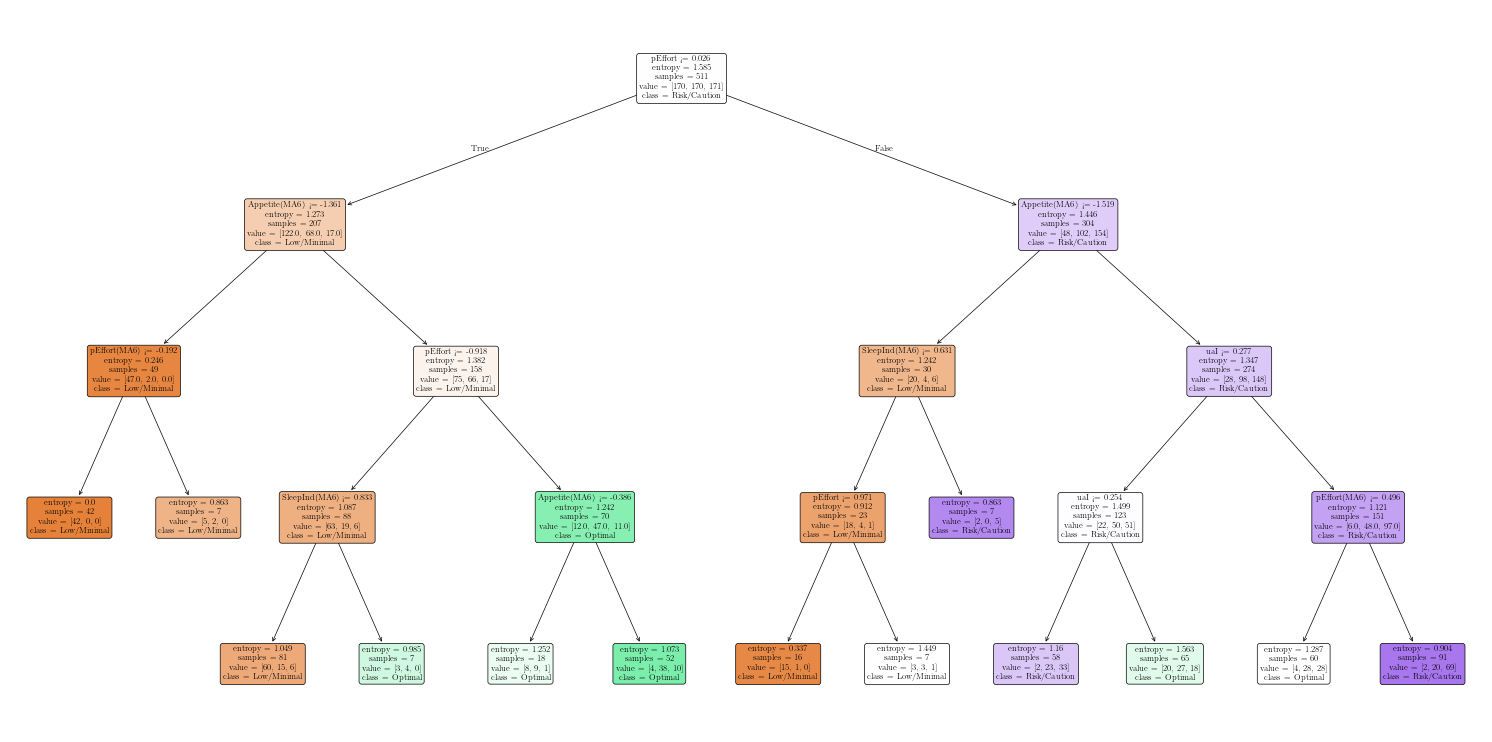

In [24]:
# Get the best estimator (best decision tree) from the random search
best_dt = random_search.best_estimator_

# Example feature names and class labels
feature_names = list(df.columns)
feature_names.remove("FatigInd")  # Replace with actual feature names

# Plot the tree with feature and class names
plt.figure(figsize=(30, 15))
plot_tree(best_dt, filled=True, feature_names=feature_names, class_names=y_train.unique(), rounded=True)
plt.tight_layout()
plt.savefig('assets/DTREE_Tree.png', transparent=True)
plt.show()


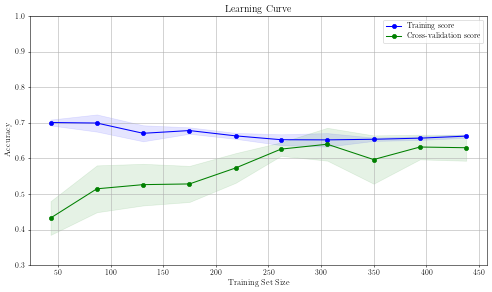

In [25]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=7, scoring='accuracy', n_jobs=-1
)

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=7, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.ylim(0.3, 1.0)
plt.tight_layout()
plt.savefig('assets/DTREE_LearningCurve.png', transparent=True)
plt.show()



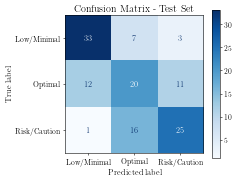

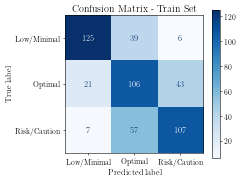

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred_test = best_model.predict(X_test)

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=best_model.classes_)
disp_test.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.savefig('assets/DTREE_ConfusionMatrixTest.png', transparent=True)
plt.show()

# Optionally, you can also generate confusion matrix for the training set
y_pred_train = best_model.predict(X_train)

# Generate the confusion matrix for the train set
cm_train = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix for the train set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=best_model.classes_)
disp_train.plot(cmap="Blues")
plt.title("Confusion Matrix - Train Set")
plt.tight_layout()
plt.savefig('assets/DTREE_ConfusionMatrixTrain.png', transparent=True)
plt.show()


In [27]:
from sklearn.metrics import classification_report

y_pred_test = best_model.predict(X_test)
report = classification_report(y_test, y_pred_test)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

 Low/Minimal       0.72      0.77      0.74        43
     Optimal       0.47      0.47      0.47        43
Risk/Caution       0.64      0.60      0.62        42

    accuracy                           0.61       128
   macro avg       0.61      0.61      0.61       128
weighted avg       0.61      0.61      0.61       128



In [28]:
y_pred_train = best_model.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

 Low/Minimal       0.82      0.74      0.77       170
     Optimal       0.52      0.62      0.57       170
Risk/Caution       0.69      0.63      0.65       171

    accuracy                           0.66       511
   macro avg       0.68      0.66      0.67       511
weighted avg       0.68      0.66      0.67       511

